In [1]:
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt

In [2]:
def set_fontsize(ax, fs, legend = False):
    """
    Small function to set font sizes for figures
    """
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.yaxis.offsetText.set_fontsize(fs)
    if legend:
        [t.set_fontsize(fs) for t in ax.legend().get_texts()]
    ax.title.set_size(int(fs*1.2))

In [3]:
# Units and constants

Jmax = 6      # max J value in Hamiltonian
I_Tl = 1/2    # I1 in Ramsey's notation
I_F = 1/2     # I2 in Ramsey's notation

# TlF constants. Data from D.A. Wilkening, N.F. Ramsey,
# and D.J. Larson, Phys Rev A 29, 425 (1984). Everything in Hz.

Brot = 6689920000
c1 = 126030.0
c2 = 17890.0
c3 = 700.0
c4 = -13300.0

D_TlF = 4.2282 * 0.393430307 *5.291772e-9/4.135667e-15 # [Hz/(V/cm)]

# Constants from Wilkening et al, in Hz/Gauss, for 205Tl

mu_J = 35
mu_Tl = 1240.5
mu_F = 2003.63

In [4]:
class BasisState:
    # constructor
    def __init__(self, J, mJ, I1, m1, I2, m2):
        self.J, self.mJ  = J, mJ
        self.I1, self.m1 = I1, m1
        self.I2, self.m2 = I2, m2

    # equality testing
    def __eq__(self, other):
        return self.J==other.J and self.mJ==other.mJ \
                    and self.I1==other.I1 and self.I2==other.I2 \
                    and self.m1==other.m1 and self.m2==other.m2

    # inner product
    def __matmul__(self, other):
        if self == other:
            return 1
        else:
            return 0

    # superposition: addition
    def __add__(self, other):
        if self == other:
            return State([ (2,self) ])
        else:
            return State([ (1,self), (1,other) ])

    # superposition: subtraction
    def __sub__(self, other):
        return self + -1*other

    # scalar product (psi * a)
    def __mul__(self, a):
        return State([ (a, self) ])

    # scalar product (a * psi)
    def __rmul__(self, a):
        return self * a
    
    def print_quantum_numbers(self):
        print( self.J,"%+d"%self.mJ,"%+0.1f"%self.m1,"%+0.1f"%self.m2 )

In [5]:
class State:
    # constructor
    def __init__(self, data=[], remove_zero_amp_cpts=True):
        # check for duplicates
        for i in range(len(data)):
            amp1,cpt1 = data[i][0], data[i][1]
            for amp2,cpt2 in data[i+1:]:
                if cpt1 == cpt2:
                    raise AssertionError("duplicate components!")
        # remove components with zero amplitudes
        if remove_zero_amp_cpts:
            self.data = [(amp,cpt) for amp,cpt in data if amp!=0]
        else:
            self.data = data
        # for iteration over the State
        self.index = len(self.data)

    # superposition: addition
    # (highly inefficient and ugly but should work)
    def __add__(self, other):
        data = []
        # add components that are in self but not in other
        for amp1,cpt1 in self.data:
            only_in_self = True
            for amp2,cpt2 in other.data:
                if cpt2 == cpt1:
                    only_in_self = False
            if only_in_self:
                data.append((amp1,cpt1))
        # add components that are in other but not in self
        for amp1,cpt1 in other.data:
            only_in_other = True
            for amp2,cpt2 in self.data:
                if cpt2 == cpt1:
                    only_in_other = False
            if only_in_other:
                data.append((amp1,cpt1))
        # add components that are both in self and in other
        for amp1,cpt1 in self.data:
            for amp2,cpt2 in other.data:
                if cpt2 == cpt1:
                    data.append((amp1+amp2,cpt1))
        return State(data)
                
    # superposition: subtraction
    def __sub__(self, other):
        return self + -1*other

    # scalar product (psi * a)
    def __mul__(self, a):
        return State( [(a*amp,psi) for amp,psi in self.data] )

    # scalar product (a * psi)
    def __rmul__(self, a):
        return self * a
    
    # scalar division (psi / a)
    def __truediv__(self, a):
        return self * (1/a)
    
    # negation
    def __neg__(self):
        return -1.0 * self
    
    # inner product
    def __matmul__(self, other):
        result = 0
        for amp1,psi1 in self.data:
            for amp2,psi2 in other.data:
                result += amp1.conjugate()*amp2 * (psi1@psi2)
        return result

    # iterator methods
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.index == 0:
            raise StopIteration
        self.index -= 1
        return self.data[self.index]
    
    # direct access to a component
    def __getitem__(self, i):
        return self.data[i]

In [6]:
def J2(psi):
    return State([(psi.J*(psi.J+1),psi)])

def Jz(psi):
    return State([(psi.mJ,psi)])

def I1z(psi):
    return State([(psi.m1,psi)])

def I2z(psi):
    return State([(psi.m2,psi)])

In [7]:
def Jp(psi):
    amp = sqrt((psi.J-psi.mJ)*(psi.J+psi.mJ+1))
    ket = BasisState(psi.J, psi.mJ+1, psi.I1, psi.m1, psi.I2, psi.m2)
    return State([(amp,ket)])

def Jm(psi):
    amp = sqrt((psi.J+psi.mJ)*(psi.J-psi.mJ+1))
    ket = BasisState(psi.J, psi.mJ-1, psi.I1, psi.m1, psi.I2, psi.m2)
    return State([(amp,ket)])

def I1p(psi):
    amp = sqrt((psi.I1-psi.m1)*(psi.I1+psi.m1+1))
    ket = BasisState(psi.J, psi.mJ, psi.I1, psi.m1+1, psi.I2, psi.m2)
    return State([(amp,ket)])

def I1m(psi):
    amp = sqrt((psi.I1+psi.m1)*(psi.I1-psi.m1+1))
    ket = BasisState(psi.J, psi.mJ, psi.I1, psi.m1-1, psi.I2, psi.m2)
    return State([(amp,ket)])

def I2p(psi):
    amp = sqrt((psi.I2-psi.m2)*(psi.I2+psi.m2+1))
    ket = BasisState(psi.J, psi.mJ, psi.I1, psi.m1, psi.I2, psi.m2+1)
    return State([(amp,ket)])

def I2m(psi):
    amp = sqrt((psi.I2+psi.m2)*(psi.I2-psi.m2+1))
    ket = BasisState(psi.J, psi.mJ, psi.I1, psi.m1, psi.I2, psi.m2-1)
    return State([(amp,ket)])

In [8]:
def Jx(psi):
    return .5*( Jp(psi) + Jm(psi) )

def Jy(psi):
    return -.5j*( Jp(psi) - Jm(psi) )

def I1x(psi):
    return .5*( I1p(psi) + I1m(psi) )

def I1y(psi):
    return -.5j*( I1p(psi) - I1m(psi) )

def I2x(psi):
    return .5*( I2p(psi) + I2m(psi) )

def I2y(psi):
    return -.5j*( I2p(psi) - I2m(psi) )

In [9]:
def com(A, B, psi):
    ABpsi = State()
    # operate with A on all components in B|psi>
    for amp,cpt in B(psi):
        ABpsi += amp * A(cpt)
    return ABpsi

In [10]:
def Hrot(psi):
    return Brot * J2(psi)

In [11]:
def Hc1(psi):
    return c1 * ( com(I1z,Jz,psi) + .5*(com(I1p,Jm,psi)+com(I1m,Jp,psi)) )

def Hc2(psi):
    return c2 * ( com(I2z,Jz,psi) + .5*(com(I2p,Jm,psi)+com(I2m,Jp,psi)) )

def Hc4(psi):
    return c4 * ( com(I1z,I2z,psi) + .5*(com(I1p,I2m,psi)+com(I1m,I2p,psi)) )

def Hc3a(psi):
    return 15*c3/c1/c2 * com(Hc1,Hc2,psi) / ((2*psi.J+3)*(2*psi.J-1))

def Hc3b(psi):
    return 15*c3/c1/c2 * com(Hc2,Hc1,psi) / ((2*psi.J+3)*(2*psi.J-1))

def Hc3c(psi):
    return -10*c3/c4/Brot * com(Hc4,Hrot,psi) / ((2*psi.J+3)*(2*psi.J-1))

In [12]:
def Hff(psi):
    return Hrot(psi) + Hc1(psi) + Hc2(psi) + Hc3a(psi) + Hc3b(psi) \
            + Hc3c(psi) + Hc4(psi)

In [13]:
def HZx(psi):
    if psi.J != 0:
        return -mu_J/psi.J*Jx(psi) - mu_Tl/psi.I1*I1x(psi) - mu_F/psi.I2*I2x(psi)
    else:
        return -mu_Tl/psi.I1*I1x(psi) - mu_F/psi.I2*I2x(psi)

def HZy(psi):
    if psi.J != 0:
        return -mu_J/psi.J*Jy(psi) - mu_Tl/psi.I1*I1y(psi) - mu_F/psi.I2*I2y(psi)
    else:
        return -mu_Tl/psi.I1*I1y(psi) - mu_F/psi.I2*I2y(psi)
    
def HZz(psi):
    if psi.J != 0:
        return -mu_J/psi.J*Jz(psi) - mu_Tl/psi.I1*I1z(psi) - mu_F/psi.I2*I2z(psi)
    else:
        return -mu_Tl/psi.I1*I1z(psi) - mu_F/psi.I2*I2z(psi)

In [14]:
def R10(psi):
    amp1 = sqrt((psi.J-psi.mJ)*(psi.J+psi.mJ)/(8*psi.J**2-2))
    ket1 = BasisState(psi.J-1, psi.mJ, psi.I1, psi.m1, psi.I2, psi.m2)
    amp2 = sqrt((psi.J-psi.mJ+1)*(psi.J+psi.mJ+1)/(6+8*psi.J*(psi.J+2)))
    ket2 = BasisState(psi.J+1, psi.mJ, psi.I1, psi.m1, psi.I2, psi.m2)
    return State([(amp1,ket1),(amp2,ket2)])

def R1m(psi):
    amp1 = -.5*sqrt((psi.J+psi.mJ)*(psi.J+psi.mJ-1)/(4*psi.J**2-1))
    ket1 = BasisState(psi.J-1, psi.mJ-1, psi.I1, psi.m1, psi.I2, psi.m2)
    amp2 = .5*sqrt((psi.J-psi.mJ+1)*(psi.J-psi.mJ+2)/(3+4*psi.J*(psi.J+2)))
    ket2 = BasisState(psi.J+1, psi.mJ-1, psi.I1, psi.m1, psi.I2, psi.m2)
    return State([(amp1,ket1),(amp2,ket2)])

def R1p(psi):
    amp1 = -.5*sqrt((psi.J-psi.mJ)*(psi.J-psi.mJ-1)/(4*psi.J**2-1))
    ket1 = BasisState(psi.J-1, psi.mJ+1, psi.I1, psi.m1, psi.I2, psi.m2)
    amp2 = .5*sqrt((psi.J+psi.mJ+1)*(psi.J+psi.mJ+2)/(3+4*psi.J*(psi.J+2)))
    ket2 = BasisState(psi.J+1, psi.mJ+1, psi.I1, psi.m1, psi.I2, psi.m2)
    return State([(amp1,ket1),(amp2,ket2)])

In [15]:
def HSx(psi):
    return -D_TlF * ( R1m(psi) - R1p(psi) )

def HSy(psi):
    return -D_TlF * 1j * ( R1m(psi) + R1p(psi) )

def HSz(psi):
    return -D_TlF * sqrt(2)*R10(psi)

In [16]:
def HI1R(psi):
    return com(I1z,R10,psi) + .5*(com(I1p,R1m,psi)+com(I1m,R1p,psi))

def HI2R(psi):
    return com(I2z,R10,psi) + .5*(com(I2p,R1m,psi)+com(I2m,R1p,psi))

In [17]:
def Hc3_alt(psi):
    return 5*c3/c4*Hc4(psi) - 15*c3/2*(com(HI1R,HI2R,psi)+com(HI2R,HI1R,psi))

In [18]:
def Hff_alt(psi):
    return Hrot(psi) + Hc1(psi) + Hc2(psi) + Hc3_alt(psi) + Hc4(psi)

In [19]:
Jmax = 6
QN = np.array([BasisState(J,mJ,I_Tl,m1,I_F,m2)
      for J in range(Jmax+1)
      for mJ in range(-J,J+1)
      for m1 in np.arange(-I_Tl,I_Tl+1)
      for m2 in np.arange(-I_F,I_F+1)])

In [20]:
%%time
def HMatElems(H, QN):
    result = np.empty((len(QN),len(QN)), dtype=complex)
    for i,a in enumerate(QN):
        for j,b in enumerate(QN):
            result[i,j] = (1*a)@H(b)
    return result

Hff_m = HMatElems(Hff, QN)
HSx_m = HMatElems(HSx, QN)
HSy_m = HMatElems(HSy, QN)
HSz_m = HMatElems(HSz, QN)
HZx_m = HMatElems(HZx, QN)
HZy_m = HMatElems(HZy, QN)
HZz_m = HMatElems(HZz, QN)

Wall time: 54.6 s


In [21]:
import itertools

def index_range(J):
    return 4*(J)**2, 4*(J+1)**2

def generate_Q0a(H0, P0, J, Jmax):
    E = np.linalg.eigh(H0)[0]
    idx_min, idx_max = index_range(J)
    Q0 = np.eye(4*(Jmax+1)**2) - P0
    for j in range(Jmax+1):
        if J != j:
            idmin, idmax = index_range(j)
            Q0[idmin:idmax,idmin:idmax] /= np.mean(E[idx_min:idx_max]) - np.mean(E[idmin:idmax])
    return Q0

def compress_variables(d):
    for order in d.keys():
        ax = list(d[order].keys())
        for axes in ax:
            for c in itertools.permutations(axes):
                c = ''.join(c)
                if c != axes:
                    if not isinstance(d[order].get(c), type(None)):
                        d[order][axes] += d[order][c]
                        ax.remove(c)
                        del d[order][c]
    return d

def generate_effective_hamiltonian_hand(H0, Hmats, J=2, Jmax = 6):
    idx_min, idx_max = index_range(J)
    P0 = np.eye(4*(Jmax+1)**2)
    mask = np.zeros(P0.shape, dtype = bool)
    mask[idx_min:idx_max, idx_min:idx_max] = True
    P0[~mask] = 0
    E = np.linalg.eigh(H0)[0]
    Q0 = generate_Q0a(H0, P0, J, Jmax)
    Q02 = Q0.copy()
    for j in range(Jmax+1):
        if J != j:
            idmin, idmax = index_range(j)
            Q02[idmin:idmax,idmin:idmax] /= np.mean(E[idx_min:idx_max]) - np.mean(E[idmin:idmax])
    Q03 = Q02.copy()
    for j in range(Jmax+1):
        if J != j:
            idmin, idmax = index_range(j)
            Q03[idmin:idmax,idmin:idmax] /= np.mean(E[idx_min:idx_max]) - np.mean(E[idmin:idmax])
    coords = ['x', 'y', 'z']
    
    Heff = dict()
    
    Heff[0] = dict()
    for ax1, H1 in zip(coords, Hmats):
        val = P0@H1@P0
        if np.abs(val).sum() == 0:
            continue
        Heff[ax1] = val[idx_min:idx_max,idx_min:idx_max]
        
    Heff[1] = dict()
    for (ax1, ax2), (H1, H2) in zip(itertools.product(*[coords]*2), itertools.product(*[Hmats]*2)):
        val = P0@H1@Q0@H2@P0
        if np.abs(val).sum() == 0:
            continue
        if ax1+ax2 in Heff[1]:
            Heff[1][ax1+ax2] += val[idx_min:idx_max,idx_min:idx_max]
        else:
            Heff[1][ax1+ax2] = val[idx_min:idx_max,idx_min:idx_max]
    
    Heff[2] = dict()
    for (ax1, ax2, ax3), (H1, H2, H3) in zip(itertools.product(*[coords]*3), itertools.product(*[Hmats]*3)):
        val = P0@H1@Q0@H2@Q0@H3@P0 - P0@H1@Q02@H2@P0@H3@P0
        if np.abs(val).sum() == 0:
            continue
        ax = ax1+ax2+ax3
        if ax in Heff[2]:
            Heff[2][ax] += val[idx_min:idx_max,idx_min:idx_max]
        else:
            Heff[2][ax] = val[idx_min:idx_max,idx_min:idx_max]
    
    Heff[3] = dict()
    for (ax1, ax2, ax3, ax4), (H1, H2, H3, H4) in zip(itertools.product(*[coords]*4), itertools.product(*[Hmats]*4)):
        val = P0@H1@Q0@H2@Q0@H3@Q0@H4@P0 - P0@H1@Q0@H2@Q02@H3@P0@H4@P0 - P0@H1@Q02@H2@Q0@H3@P0@H4@P0 + P0@H1@Q03@H2@P0@H3@P0@H4@P0 - P0@H1@Q02@H2@P0@H3@Q0@H4@P0
        if np.abs(val).sum() == 0:
            continue
        ax = ax1+ax2+ax3+ax4
        if ax in Heff[3]:
            Heff[3][ax] += val[idx_min:idx_max,idx_min:idx_max]
        else:
            Heff[3][ax] = val[idx_min:idx_max,idx_min:idx_max]
    return Heff

def generate_effective_hamiltonian(H0, Hmats, J = 2, order = 2, Jmax = 6):
    idx_min, idx_max = index_range(J)
    P0 = np.eye(4*(Jmax+1)**2)
    mask = np.zeros(P0.shape, dtype = bool)
    mask[idx_min:idx_max, idx_min:idx_max] = True
    P0[~mask] = 0
    
    Q0 = generate_Q0a(H0, P0, J, Jmax)
    
    coords = ['x', 'y', 'z']
    
    U = dict([(0,dict([('', P0)]))])
    for o in range(1, order+1):
        U[o] = dict()
        for axis, Hpert in zip(coords, Hmats):
            for axes, mat in U[o-1].items():
                product = Q0@(Hpert@mat)
                if np.abs(product).sum() == 0:
                    continue
                if axis+axes in U[o]:
                    U[o][axis+axes] += product
                else:
                    U[o][axis+axes] = product
            
        for axis, Hpert in zip(coords, Hmats):
            for p in range(1,o):
                for axes_p, mat_p in U[p].items():
                    for axes, mat in U[o-p-1].items():
                        product = Q0@(mat_p@Hpert@mat)
                        if np.abs(product).sum() == 0:
                            continue
                        if axis+axes_p+axes in U[o]:
                            U[o][axis+axes_p+axes] -= product
                        else:
                            U[o][axis+axes_p+axes] = -product
        U = compress_variables(U)
    
    Heff = dict()
    for o in range(order+1):
        Heff[o] = dict()
        for axis, Hpert in zip(coords, Hmats):
            for axes, mat in U[o].items():
                product = P0@Hpert@mat
                if np.abs(product).sum() == 0:
                    continue
                if axis+axes in Heff[o]:
                    Heff[o][axis+axes] += (P0@Hpert@mat)[idx_min:idx_max, idx_min:idx_max]
                else:
                    Heff[o][axis+axes] = (P0@Hpert@mat)[idx_min:idx_max,idx_min:idx_max]
    
    
                
    return U, Heff

In [22]:
from sympy import *

def generate_U_testing(Hmats, J = 2, order = 3, Jmax = 6):
    idx_min, idx_max = index_range(J)
    P0 = MatrixSymbol("P0", 196,196)
    Q0 = MatrixSymbol('Q0', 196,196)
    Hmats = [MatrixSymbol(val, 196,196) for val in Hmats]
    coords = ['x', 'y', 'z']
    
    U = dict([(0,dict([('', P0)]))])
    for o in range(1, order+1):
        U[o] = dict()
        for axis, Hpert in zip(coords, Hmats):
            for axes, mat in U[o-1].items():
                product = Q0*Hpert*mat
                if axis+axes in U[o]:
                    U[o][axis+axes] += product
                else:
                    U[o][axis+axes] = product
            
        for axis, Hpert in zip(coords, Hmats):
            for p in range(1,o):
                for axes_p, mat_p in U[p].items():
                    for axes, mat in U[o-p-1].items():
                        product = Q0*mat_p*Hpert*mat
                        if axis+axes_p+axes in U[o]:
                            U[o][axis+axes_p+axes] -= product
                        else:
                            U[o][axis+axes_p+axes] = -product
    Heff = dict()
    for o in range(order+1):
        Heff[o] = dict()
        for axis, Hpert in zip(coords, Hmats):
            for axes, mat in U[o].items():
                product = P0*Hpert*mat
                if axis+axes in Heff[o]:
                    Heff[o][axis+axes] += (product)
                else:
                    Heff[o][axis+axes] = (product)
                
    return U, Heff

In [76]:
U, HeffSymbolic = generate_U_testing(['HSx', 'HSy', 'HSz'], order = 3)

In [77]:
U[1]['x']

Q0*HSx*P0

In [78]:
U[2]['xx']

-Q0**2*HSx*P0*HSx*P0 + Q0*HSx*Q0*HSx*P0

In [79]:
U[3]['yxx']

-Q0**2*HSx*P0*HSy*Q0*HSx*P0 - Q0*(-Q0**2*HSx*P0*HSx*P0 + Q0*HSx*Q0*HSx*P0)*HSy*P0 + Q0*HSy*(-Q0**2*HSx*P0*HSx*P0 + Q0*HSx*Q0*HSx*P0)

In [80]:
HeffSymbolic[3]['xyxx']

P0*HSx*(-Q0**2*HSx*P0*HSy*Q0*HSx*P0 - Q0*(-Q0**2*HSx*P0*HSx*P0 + Q0*HSx*Q0*HSx*P0)*HSy*P0 + Q0*HSy*(-Q0**2*HSx*P0*HSx*P0 + Q0*HSx*Q0*HSx*P0))

In [82]:
H0 = Hrot_m
Jmax = 6
J = 2
idx_min, idx_max = index_range(J)
P0 = np.eye(4*(Jmax+1)**2)
mask = np.zeros(P0.shape, dtype = bool)
mask[idx_min:idx_max, idx_min:idx_max] = True
P0[~mask] = 0

Q0 = generate_Q0a(H0, P0, J, Jmax)
del H0

In [150]:
Hrot_m = Hff_m = HMatElems(Hrot, QN)

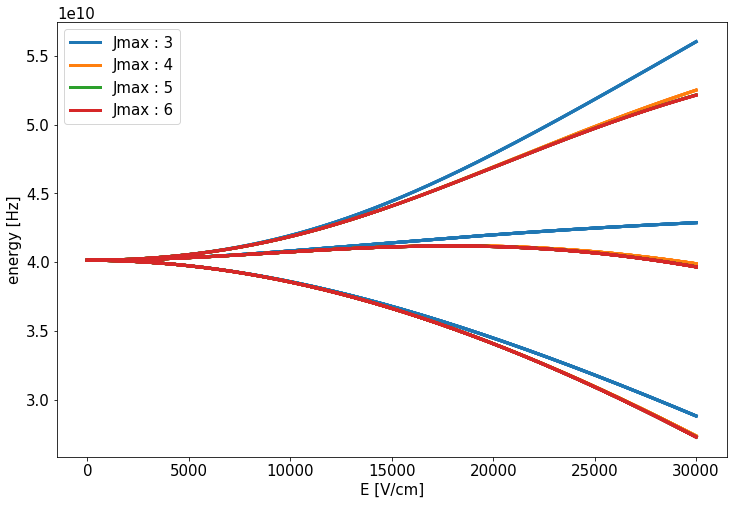

In [151]:
fig, ax = plt.subplots(figsize = (12,8))
E = np.linspace(0,30000,501)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
for jmax in range(3,7):
    idmax = 4*(jmax+1)**2
    Elevels = np.linalg.eigh(Hrot_m[:idmax,:idmax]+np.einsum('i,jk -> ijk', E, HSz_m[:idmax,:idmax]))[0]
    ax.plot(E, Elevels[:,16:35], colors[jmax-3], lw = 3)
    ax.plot(E, Elevels[:,35], colors[jmax-3], label = f'Jmax : {jmax}', lw = 3)
ax.legend(fontsize = 15)
ax.set_xlabel('E [V/cm]')
ax.set_ylabel('energy [Hz]')
set_fontsize(ax, 15)

So the bending of the energy levels comes about due to the higher order J states coupling back to J=2 at high fields (which makes the coupling stronger).

## Toy Model $H_{rot}+H_{stark}$

In [83]:
Hrot_m = Hff_m = HMatElems(Hrot, QN)

In [ ]:
%%time
U, Hpertubation = generate_effective_hamiltonian(Hrot_m, [HSx_m, HSy_m, HSz_m], J=2, order = 13, Jmax = 6)
del U

In [ ]:
import pickle
with open('Heff_13th_toy.dat', 'wb') as wfp:
    pickle.dump(Hpertubation, wfp)

In [ ]:
Hpertubation_manual = generate_effective_hamiltonian_hand(Hrot_m, [HSx_m, HSy_m, HSz_m], J=2, Jmax = 6)

In [ ]:
Hrot_m = HMatElems(Hrot,QN)

def Hfull(Ex, Ey, Ez):
    return Hrot_m + Ex*HSx_m + Ey*HSy_m + Ez*HSz_m

In [ ]:
def Heff(H0, Hpertubation, Ex, Ey, Ez, J = 2):
    E = dict([('', 1), ('x', Ex), ('y', Ey), ('z', Ez)])
    idx_min, idx_max = index_range(J)
    
    Heff = np.zeros([4*(2*J+1), 4*(2*J+1)], dtype = 'complex')
    for axes, Hpert in Hpertubation.items():
        Eval = np.product([E[ax] for ax in axes])
        Heff += Eval*Hpert
    
    return H0[idx_min:idx_max, idx_min:idx_max] + Heff

In [ ]:
Hpert = dict()
for H in Hpertubation.values():
    Hpert.update(H)

In [ ]:
Emax = 5000
Ex = np.linspace(0,Emax,101)
# Ex = np.zeros(101)
Ey = np.linspace(0,Emax,101)
# Ey = np.zeros(101)
Ez = np.linspace(0,Emax,101)
E = np.sqrt(Ex**2+Ey**2+Ez**2)

In [ ]:
Hfull_numerical = np.array([Hfull(Exi, Eyi ,Ezi) for Exi, Eyi, Ezi in zip(Ex, Ey, Ez)])
energies_full, eigvecs = np.linalg.eigh(Hfull_numerical)

Heff_numerical = np.array([Heff(Hrot_m, Hpert, Exi,Eyi,Ezi) for Exi, Eyi, Ezi in zip(Ex, Ey, Ez)])
energies_eff, eigvecs = np.linalg.eigh(Heff_numerical)

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E, energies_full[:,16:36], '-', lw = 3);
ax.set_title(r'H$_{full}$')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E, energies_eff, '-', lw = 3);
ax.set_xlabel(r'E [V/cm]')
ax.set_title(r'H$_{eff}$')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
l1 = ax.plot(E, energies_eff, 'C0-', lw = 3, label = r'H$_{eff}$', alpha = 0.8);
l2 = ax.plot(E, energies_full[:,16:36], 'C3.', label = r'H$_{full}$');
ax.legend([l1[0],l2[0]], [l1[0].get_label(),l2[0].get_label()], fontsize = 15)
ax.set_xlabel(r'E [V/cm]')
ax.set_title(r'H')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E, 100*(energies_eff-energies_full[:,16:36])/(energies_full[:,16:36] - energies_full[0,16:36]), lw = 3);
ax.set_title(r'$\Delta$E')
ax.set_xlabel(r'E [V/cm]')
ax.set_ylabel(r'$\left(E_{full}-E_{eff}\right)/\left(E_{full}-E_{rot}\right)$ [%]')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
set_fontsize(ax, 15)

In [ ]:
Emax = 150000
# Ex = np.linspace(0,Emax,101)
Ex = np.zeros(101)
# Ey = np.linspace(0,Emax,101)
Ey = np.zeros(101)
Ez = np.linspace(0,Emax,101)
E = np.sqrt(Ex**2+Ey**2+Ez**2)


for order in range(1,12,2):
    U, Hpertubation = generate_effective_hamiltonian(Hrot_m, [HSx_m, HSy_m, HSz_m], J=2, order = order, Jmax = 6)
    Hpert = dict()
    for H in Hpertubation.values():
        Hpert.update(H)

    Hfull_numerical = np.array([Hfull(Exi, Eyi ,Ezi) for Exi, Eyi, Ezi in zip(Ex, Ey, Ez)])
    energies_full, eigvecs = np.linalg.eigh(Hfull_numerical)

    Heff_numerical = np.array([Heff(Hrot_m, Hpert, Exi,Eyi,Ezi) for Exi, Eyi, Ezi in zip(Ex, Ey, Ez)])
    energies_eff, eigvecs = np.linalg.eigh(Heff_numerical)
    
    fig, ax = plt.subplots(figsize = (12,8))
    ax.plot(E, 100*(energies_eff-energies_full[:,16:36])/(energies_full[:,16:36] - energies_full[0,16:36]), lw = 3);
    ax.set_title(r'$\Delta$E'+f', order = {order}')
    ax.set_xlabel(r'E [V/cm]')
    ax.set_ylabel(r'$\left(E_{full}-E_{eff}\right)/\left(E_{full}-E_{rot}\right)$ [%]')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    set_fontsize(ax, 15)
del U, Hpertubation, Hpert, Hfull_numerical, Heff_numerical, energies_full, energies_eff, eigvecs

## Full Hamiltonian @ 20 Gaus $B_z$

In [45]:
U, Hpertubation = generate_effective_hamiltonian(Hff_m+20*HZz_m, [HSx_m, HSy_m, HSz_m], J=2, order = 9, Jmax = 6)

In [46]:
def Hfull(Ex, Ey, Ez):
    return Hff_m + 20*HZz_m + Ex*HSx_m + Ey*HSy_m + Ez*HSz_m

In [47]:
Hpert = dict()
for H in Hpertubation.values():
    Hpert.update(H)

In [54]:
Emax = 90
steps = 101
# Ex = np.linspace(0,Emax,steps)
Ex = np.zeros(steps)
# Ey = np.linspace(0,Emax,steps)
Ey = np.zeros(steps)
Ez = np.linspace(0,Emax,steps)
E = np.sqrt(Ex**2+Ey**2+Ez**2)

In [59]:
Hfull_numerical = np.array([Hfull(Exi, Eyi ,Ezi) for Exi, Eyi, Ezi in zip(Ex, Ey, Ez)])
energies_full, eigvecs = np.linalg.eigh(Hfull_numerical)

Heff_numerical = np.array([Heff(Hff_m+20*HZz_m, Hpert, Exi,Eyi,Ezi) for Exi, Eyi, Ezi in zip(Ex, Ey, Ez)])
energies_eff, eigvecs = np.linalg.eigh(Heff_numerical)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


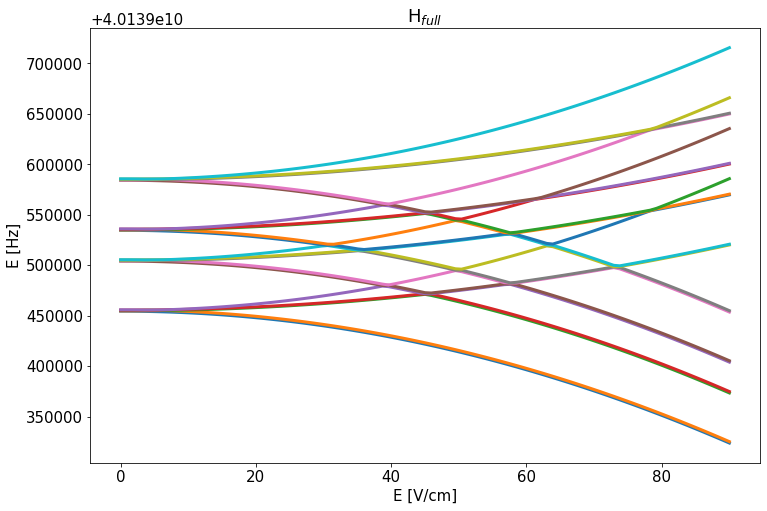

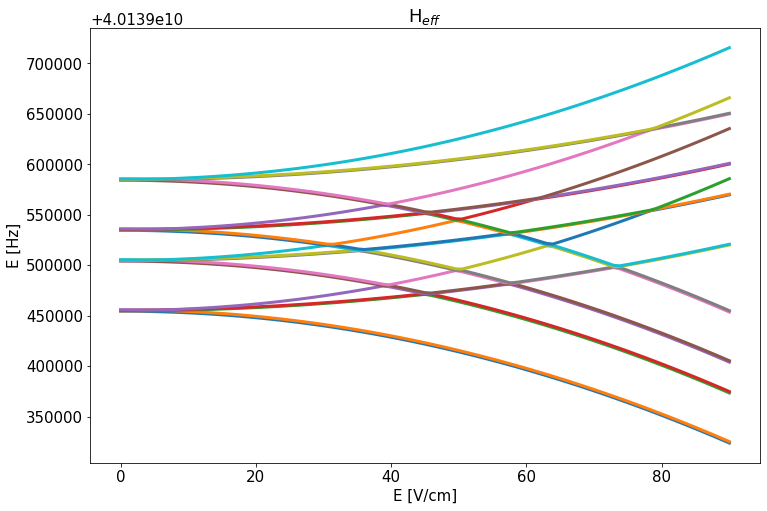

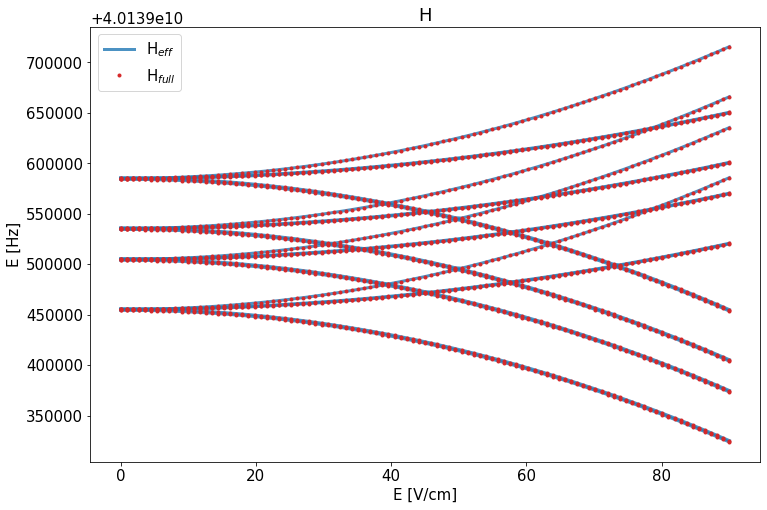

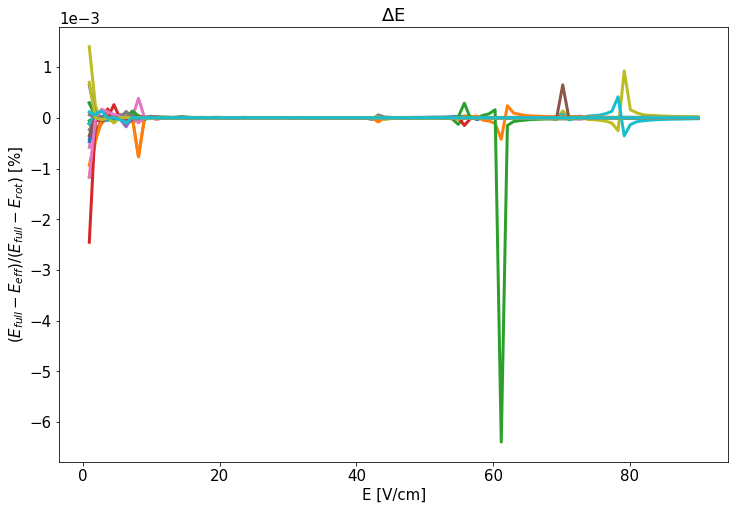

In [60]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E, energies_full[:,16:36], '-', lw = 3);
ax.set_title(r'H$_{full}$')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E, energies_eff, '-', lw = 3);
ax.set_xlabel(r'E [V/cm]')
ax.set_title(r'H$_{eff}$')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
l1 = ax.plot(E, energies_eff, 'C0-', lw = 3, label = r'H$_{eff}$', alpha = 0.8);
l2 = ax.plot(E, energies_full[:,16:36], 'C3.', label = r'H$_{full}$');
ax.legend([l1[0],l2[0]], [l1[0].get_label(),l2[0].get_label()], fontsize = 15)
ax.set_xlabel(r'E [V/cm]')
ax.set_title(r'H')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E, 100*(energies_eff-energies_full[:,16:36])/(energies_full[:,16:36] - energies_full[0,16:36]), lw = 3);
ax.set_title(r'$\Delta$E')
ax.set_xlabel(r'E [V/cm]')
ax.set_ylabel(r'$\left(E_{full}-E_{eff}\right)/\left(E_{full}-E_{rot}\right)$ [%]')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
set_fontsize(ax, 15)

## Full Effective Hamiltonian @0.5G, 400 V/cm for Jakob to compare with his method

In [61]:
U, Hpertubation = generate_effective_hamiltonian(Hff_m+0.5*HZz_m, [HSx_m, HSy_m, HSz_m], J=2, order = 9, Jmax = 6)

In [62]:
Hpert = dict()
for H in Hpertubation.values():
    Hpert.update(H)

In [74]:
%%timeit
Heff_numerical = Heff(Hff_m+0.5*HZz_m, Hpert, 0,0,400)

7.25 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
